In [1]:

%pprint

Pretty printing has been turned OFF



# Data Scientist Technical Interview Challenge
----


## Problem Statement Summary
Your task is to build a classifier that can determine what the user is doing with their wrist during each whole body movement.
- Determine how many different wrist-motion classes there are, and (if possible) use features to identify what motion each class is representing.
- Produce quantitative estimates of the generalization performance of your classifier.
- Provide a brief (1-2 page report) describing your process, methods, and results.
- Please perform this exercise in Python, and produce clean, readable code that could be readily used by other engineers in a cloud-based (i.e., notebook server) environment.
- Be sure to publish your code to a public GitHub repository and link this repository in your report.

Have fun!


## Import packages and function definition

In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

# Get an instance of the storage calss
from storage import Storage
s = Storage()


## Data Exploration

Much of the time spent on this task is going to be spent getting familiar with the data, learning as much as possible from its structure and searching for transformations that might expose measurable differences between wrist motions that would aid in classification. This section of the report will describe some of that process.

In [11]:

import pandas as pd
import os

csv_path = os.path.join(s.data_csv_folder, 'pison_data_interview.csv')
pison_df = pd.read_csv(os.path.abspath(csv_path), encoding=s.encoding_type, header=None)


## Data Formats
A csv file attached to the email contains Pison device data. Each row is a sample. The
columns are as follows:
- timestamp (milliseconds with microsecond precision);
- channel 0 raw, channel 1 raw, channel 0 high-passed, and channel 1 high-passed (all in ADC counts);
- quaternion x, y, z, and w;
- gyroscope x, y, and z in degrees per second;
- accelerometer x, y, and z in meters per second squared;
- body movement label;
- and finally, repetition number (where there is one "repetition" for a given prompting window).

The body movement coding is:
- 0 = standing #1,
- 1 = standing #2,
- 2 = walking,
- 3 = walking fast,
- 4 = running.

The accelerometer and gyroscope coordinates follow the ENU convention:
- The X-axis points East.
- The Y-axis points North.
- The Z-axis points Up.

The quaternion coordinates follow the convention:
- The X-axis points West.
- The Y-axis points South.
- The Z-axis points Up.

In [54]:

pison_df.columns = [
    'timestamp_in_milliseconds',
    'channel_0_raw_in_ADC_counts',
    'channel_1_raw_in_ADC_counts',
    'channel_0_high_passed_in_ADC_counts',
    'channel_1_high_passed_in_ADC_counts',
    'quaternion_x',
    'quaternion_y',
    'quaternion_z',
    'quaternion_w',
    'gyroscope_x_in_degrees_per_second',
    'gyroscope_y_in_degrees_per_second',
    'gyroscope_z_in_degrees_per_second',
    'accelerometer_x_in_meters_per_second_squared',
    'accelerometer_y_in_meters_per_second_squared',
    'accelerometer_z_in_meters_per_second_squared',
    'body_movement_label',
    'prompting_window_repetition_number']
pison_df = pison_df.sort_values('timestamp_in_milliseconds')
pison_df.sample(6).T

,10225,6707,11781,9956,6735,5505
timestamp_in_milliseconds,1.587138e+06,1.560047e+06,1.596080e+06,1.582209e+06,1.560131e+06,1.552318e+06
channel_0_raw_in_ADC_counts,1.256042e+07,1.256269e+07,1.295544e+07,1.295321e+07,1.265125e+07,1.310999e+07
channel_1_raw_in_ADC_counts,1.269986e+07,1.253970e+07,1.232865e+07,1.154423e+07,1.217288e+07,1.165656e+07
channel_0_high_passed_in_ADC_counts,2.296200e+04,-2.813200e+04,-2.359700e+04,-6.273800e+04,-1.304000e+04,-1.115900e+04
channel_1_high_passed_in_ADC_counts,5.608200e+04,5.144000e+03,-6.207900e+04,3.095000e+04,3.711100e+04,9.747000e+03
quaternion_x,1.582642e-01,1.304321e-01,3.249512e-01,4.719238e-01,3.336182e-01,7.014771e-01
quaternion_y,6.611938e-01,8.880615e-02,-6.000977e-01,7.653809e-02,9.594727e-02,9.417725e-02
quaternion_z,7.301025e-01,5.310059e-03,-6.605835e-01,3.997803e-02,4.022217e-02,1.358032e-01
quaternion_w,6.909180e-02,9.874878e-01,3.131103e-01,8.774414e-01,9.370117e-01,6.932983e-01
gyroscope_x_in_degrees_per_second,-2.506690e+01,-2.276164e+02,1.007152e+00,-4.645770e+02,-3.248066e+02,-2.512286e+01



## Feature generation and data wrangling
### Elapsed time

Looking at the timestamps shows a regular pause of 4 seconds that create distict data collection periods because the device is not collecting data.

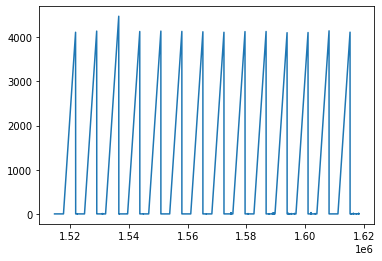

In [91]:

import matplotlib.pyplot as plt

pison_df['elapsed_milliseconds'] = pison_df.timestamp_in_milliseconds.diff()
fig, ax = plt.subplots()
line2d_objs_list = ax.plot(pison_df.timestamp_in_milliseconds, pison_df.elapsed_milliseconds, label='Elapsed Time')

In [122]:

mask_series = (pison_df.elapsed_milliseconds > 4_000)
df = pison_df[mask_series].timestamp_in_milliseconds
spike_times_list = df.tolist()
mean = df.diff().mean()/1_000
std = df.diff().std()/1_000
print(f'There are {len(spike_times_list)+1} distinct data collection periods, each lasting {mean:0.2} +-{std:0.1} seconds.')

There are 15 distinct data collection periods, each lasting 7.2 +-0.1 seconds.



That happens right at the time of the body movement label (and repetition number) change

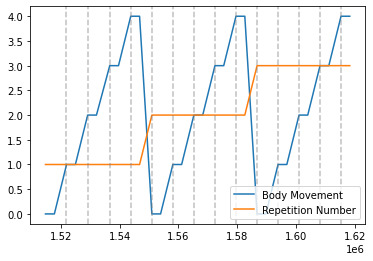

In [118]:

fig, ax = plt.subplots()
ax.plot(pison_df.timestamp_in_milliseconds, pison_df.body_movement_label, label='Body Movement')
ax.plot(pison_df.timestamp_in_milliseconds, pison_df.prompting_window_repetition_number, label='Repetition Number')
plt.legend()
for x in spike_times_list:
    plt.axvline(x=x, alpha=0.5, ls='--', c='gray')


Examining the Body Movement and Repetition Number columns shows that each "window" is given one label for each of these columns. As we progress through the 15 windows, Body Movement cycles in order through its range of 5 values three times. Repetition Number stays constant at 1 through the first five windows (representing the first set of five body movements), 2 for the second five, and 3 for the final five prompting windows. From this we can infer that there are 5 wrist motion classes, because each class is repeated exactly 3 times in the 15 windows.

Looking between these pauses shows samples collected roughly every 3 milliseconds (+/- 0.06 ms).

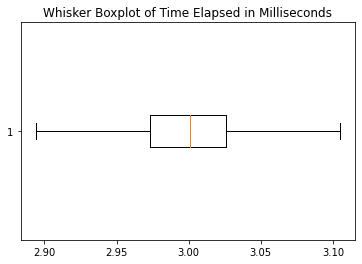

In [55]:

fig, ax = plt.subplots()
ax.set_title('Whisker Boxplot of Time Elapsed in Milliseconds')
whiskers_dict = ax.boxplot(pison_df.elapsed_milliseconds.dropna().values, vert=False, showfliers=False)

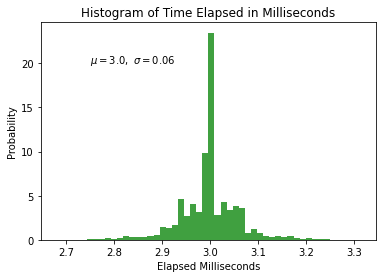

In [108]:

mask_series = (pison_df.elapsed_milliseconds < 4)
n, bins, patches = plt.hist(diff_series[mask_series], 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Elapsed Milliseconds')
plt.ylabel('Probability')
plt.title('Histogram of Time Elapsed in Milliseconds')
mean = pison_df.elapsed_milliseconds[mask_series].mean()
std = pison_df.elapsed_milliseconds[mask_series].std()
text_obj = plt.text(2.75, 20, rf'$\mu={mean:0.2},\ \sigma={std:0.2}$')


## Determine how many different wrist-motion classes there are, and (if possible) use features to identify what motion each class is representing.

Let's see if we can visualize the data in a scatter plot

In [125]:

from sklearn import manifold
from sklearn.preprocessing import StandardScaler

tsne_obj = manifold.TSNE(n_components=2, init='pca', random_state=0)
columns_list = [
    'channel_0_raw_in_ADC_counts',
    'channel_1_raw_in_ADC_counts',
    'channel_0_high_passed_in_ADC_counts',
    'channel_1_high_passed_in_ADC_counts',
    'quaternion_x',
    'quaternion_y',
    'quaternion_z',
    'quaternion_w',
    'gyroscope_x_in_degrees_per_second',
    'gyroscope_y_in_degrees_per_second',
    'gyroscope_z_in_degrees_per_second',
    'accelerometer_x_in_meters_per_second_squared',
    'accelerometer_y_in_meters_per_second_squared',
    'accelerometer_z_in_meters_per_second_squared']
X1 = pison_df[columns_list].fillna(0).values
scaler = StandardScaler().fit(X1)
X1_scaled = scaler.transform(X1)
y1 = tsne_obj.fit_transform(X1_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


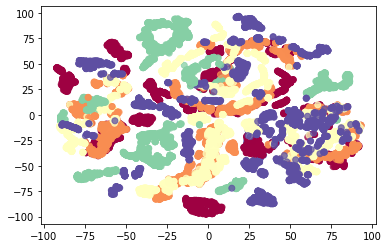

In [127]:

fig, ax = plt.subplots()
ax.scatter(y1[:, 0], y1[:, 1], c=pison_df.body_movement_label.tolist(), cmap=plt.cm.Spectral, alpha=0.75)